In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from ROHSApy import ROHSA
import scipy.stats as stats
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import matplotlib.cm as cm


## Loading the data cube

In [2]:
hdul = fits.open("GHIGLS_G86_Tb.fits") # header data unit list
hdu = hdul[0] #header data unit
hdr = hdu.header #header
data_cube = hdu.data[0]
core = ROHSA(data_cube, hdr, "GHIGLS_G86_Tb.fits")

## Extracting spectrum for a single pixel

Text(0.5, 1.0, 'Spectrum of GHIGLS_G86_Tb.fits')

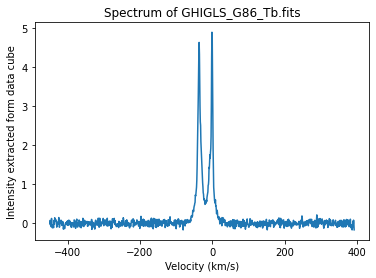

In [3]:
pixel_for_plot = (45,45)
spectrum = data_cube[:,pixel_for_plot[0],pixel_for_plot[1]]
velocities = core.v
velocities = np.flip(velocities)
spectrum = np.flip(spectrum)
plt.plot(velocities, spectrum)
plt.xlabel("Velocity (km/s)")
plt.ylabel("Intensity extracted form data cube")
plt.title("Spectrum of GHIGLS_G86_Tb.fits")

~As can be seen above we do have two main peaks!~

## Finding Moments of the spectrum

In [4]:
def moment(x,p,k,c):
    """
    Calculates the kth moment of x with distribution p and c as center

    Args:
        x (np.ndarray): independent variable
        p (np.ndarray): probability distribution
        c (float): reference for the moment i.e., k-th moment = sum(p*(x-c)**k)
    """
    return np.sum(((x-c)**k)*p)/np.sum(p)

# for printing stuff
def print_moments(velocities, spectrum):
    mean_velocity = moment(velocities, spectrum, 1, 0)
    standard_deviation = (moment(velocities, spectrum, 2, mean_velocity))**0.5
    skewness = moment(velocities, spectrum, 3, mean_velocity)/standard_deviation**3
    kurtosis = moment(velocities, spectrum, 4, mean_velocity)/standard_deviation**4
    
    print("Mean velocity:", mean_velocity, "km/s")
    print("Standard deviation:", standard_deviation, "km/s")
    print("Skewness:", skewness)
    print("Kurtosis:", kurtosis)

# Test the moment function
# x = np.linspace(0, 10, 100)
# p = np.exp(-(x-5)**2/2)
# plt.plot(x, p)
# for i in range(1, 3):
#     print("Moment", i, ":", moment(x, p, i))


In [5]:
# probability distribution from the spectrum
minimum_possible_intensity = np.min(spectrum)
prob_dist = spectrum - minimum_possible_intensity
prob_dist = prob_dist/np.sum(prob_dist)

In [6]:
print_moments(velocities, spectrum)

# In units of Column Density


Mean velocity: -20.432771765296806 km/s
Standard deviation: 17.102151706247863 km/s
Skewness: 7.307203281066898
Kurtosis: -885.6935080484308


## Dividing the spectrum into two velocity ranges and finding the moments

Since there are two peaks we can divide the spectrum into two velocity ranges that contain only a single peak and find the moments. In order to do that we need to find the local minimum of the distribution between the two peaks. And the region that we need to consider is within (-50, 50) km/s since peak are present only in this region.

Peaks indexes: [514 537 558]
Peaks are at velocities: [-36.19426125 -17.68090832  -0.77541487]
Initial velocity range: -449.3317113481132 to 392.6137384951109


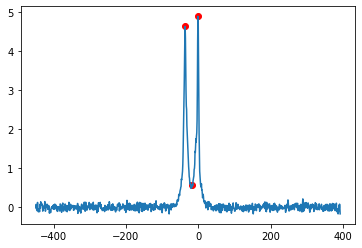

In [7]:
peaks, _ = find_peaks(spectrum, width=1, height=0.5, )
plt.plot(velocities[peaks], spectrum[peaks], "ro")
plt.plot(velocities, spectrum)
peaks_vel = velocities[peaks]
print("Peaks indexes:", peaks)
print("Peaks are at velocities:", peaks_vel)
print("Initial velocity range:", np.min(velocities), "to", np.max(velocities))


The main peaks are at velocities : -36.19426125 km/s and -0.77541487 km/s. These correspond to the indexes 514 and 558 in the spectrum array. And the local minimum is at velocity -17.68090832 km/s. This corresponds to the index 537. So we'll seperate into two velocity ranges: (-100, -17.68090832) km/s and (-17.68090832, 50) km/s. Since the tails are nearly constant apart from the noise so it is not necessary to consider the tails.

Text(0, 0.5, 'Intensity')

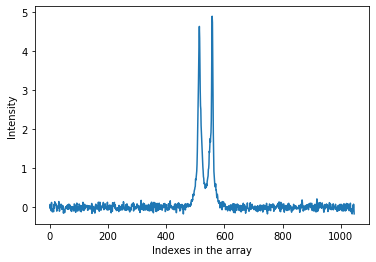

In [8]:
plt.plot(spectrum)
plt.xlabel("Indexes in the array")
plt.ylabel("Intensity")

In [9]:
right_part_velocities = velocities[peaks[1]:600]
right_part_spectrum = spectrum[peaks[1]:600]

left_part_velocities = velocities[400:peaks[1]]
left_part_spectrum = spectrum[400:peaks[1]]

Mean velocity: -36.83919964318618 km/s
Standard deviation: 10.115934829842644 km/s
Skewness: -2.3645335224101913
Kurtosis: 14.147285386395446


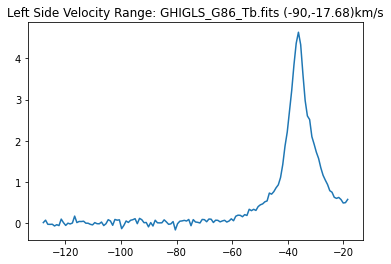

In [10]:
# Velocitiy Range 1
plt.title("Left Side Velocity Range: GHIGLS_G86_Tb.fits (-90,-17.68)km/s")
plt.plot(left_part_velocities, left_part_spectrum)
print_moments(left_part_velocities, left_part_spectrum)


Mean velocity: -1.5245469218482248 km/s
Standard deviation: 7.75119627037647 km/s
Skewness: 0.8754639186230907
Kurtosis: 5.585697462953123


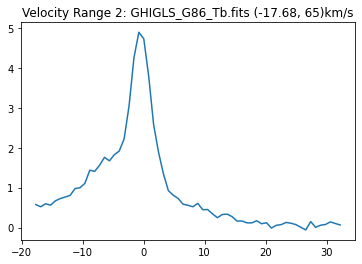

In [11]:
# Velocitiy Range 2
plt.title("Velocity Range 2: GHIGLS_G86_Tb.fits (-17.68, 65)km/s")
plt.plot(right_part_velocities, right_part_spectrum)
print_moments(right_part_velocities, right_part_spectrum)


## Measuring the noise in the spectrum

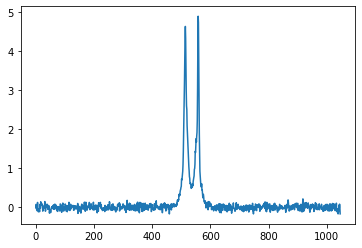

In [12]:
plt.plot(spectrum)

Noisy tails are in the range of indexes: (0, 400) and (600, 1047).

In [13]:
# Left Noisy tail
left_tail = spectrum[:400]
avg_noise_left = np.std(left_tail)

# Right Noisy tail
right_tail = spectrum[600:]
avg_noise_right = np.std(right_tail)

print("Average noise in the left tail:", avg_noise_left)
print("Average noise in the right tail:", avg_noise_right)

Average noise in the left tail: 0.063227735
Average noise in the right tail: 0.0624478


The noise from the two tails turns out to be nearly the same but with opposite sign. They are very close to 0.

## Fitting Gaussians to the spectrum

Parameters: [  3.74154729 -35.77388642   5.13080034]


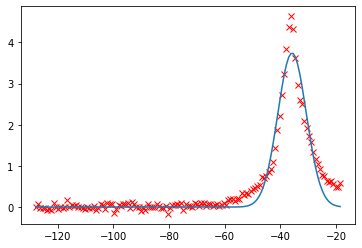

In [14]:
def gaussian(x, a, mu, sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

def gaussian_fit_plot(x, y, initial_guess):
    cf = curve_fit(gaussian, x, y, p0=initial_guess)
    parameters = cf[0]

    plt.plot(x, y, "rx")
    plt.plot(x, gaussian(x, *parameters))
    print("Parameters:", parameters)
    
    return parameters

def gaussian_plot(x, y, params):
    plt.plot(x, y, "rx")
    plt.plot(x, gaussian(x, *params))
    print("Parameters:", params)
    return params

# Left Part of the spectrum
parameters_left = gaussian_fit_plot(left_part_velocities, left_part_spectrum, 
                                    [np.max(left_part_spectrum), -36.8, 102])


Parameters: [ 3.60039997 -1.2926211   4.22801242]


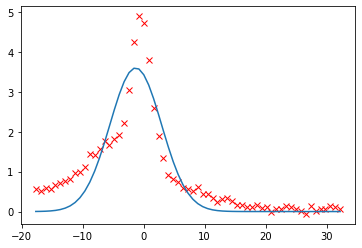

In [15]:

# Right Part of the spectrum

parameters_right = gaussian_fit_plot(right_part_velocities, right_part_spectrum, [np.max(right_part_spectrum), -3, 60])

In the above approach we used the initial guess for mean and standard deviation to be the same as the experimentally calculated values. But let's try to find the best fit for the Gaussians by tweaking the parameters a little bit.

Parameters: [4.676934112500001, -35.77388642, 5.13080034]


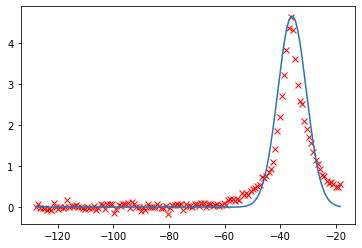

In [16]:
# Tweaking left Part of the spectrum
tweaked_left_params = gaussian_plot(left_part_velocities, left_part_spectrum, [1.25*3.74154729, -35.77388642,  5.13080034])

Parameters: [5.040559957999999, -0.49262110000000003, 2.11400621]


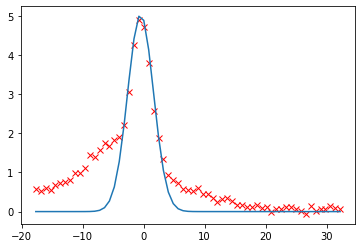

In [17]:
# Tweaking Right Part of the spectrum
tweaked_right_params = gaussian_plot(right_part_velocities, right_part_spectrum, [1.4*3.60039997, -1.2926211+0.8, 0.5*4.22801242])


## The Combined Gaussian fit

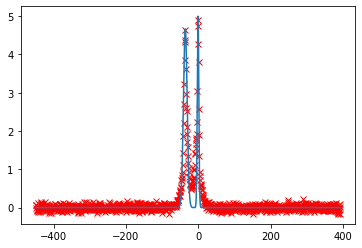

In [18]:
def gaussian_combined(x, param_left, param_right):
    return gaussian(x, *param_left) + gaussian(x, *param_right)

plt.plot(velocities,spectrum, "rx")
plt.plot(velocities, gaussian_combined(velocities, tweaked_left_params, tweaked_right_params))

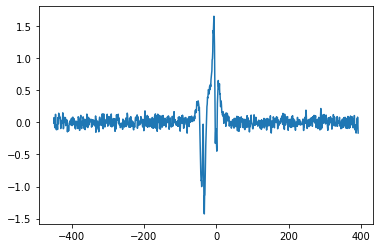

In [19]:
#residual plot
plt.plot(velocities, spectrum - gaussian_combined(velocities, tweaked_left_params, tweaked_right_params))

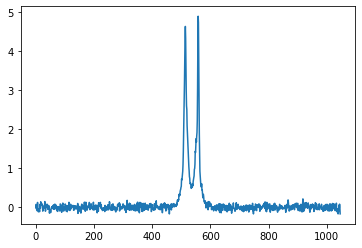

In [20]:
plt.plot(spectrum)

In [21]:
# Cutted Spectrum
print_moments(velocities, spectrum)


Mean velocity: -20.432771765296806 km/s
Standard deviation: 17.102151706247863 km/s
Skewness: 7.307203281066898
Kurtosis: -885.6935080484308


## Comparison of the moments

### 1. For the left velocity range

In [22]:
# For Left Part of the spectrum
print("Observed values:")
print_moments(left_part_velocities, left_part_spectrum)

print("\nFitted values:")
print("Mean velocity:", parameters_left[1], "km/s")
print("Standard deviation:", parameters_left[2], "km/s")

Observed values:
Mean velocity: -36.83919964318618 km/s
Standard deviation: 10.115934829842644 km/s
Skewness: -2.3645335224101913
Kurtosis: 14.147285386395446

Fitted values:
Mean velocity: -35.77388641653585 km/s
Standard deviation: 5.1308003351219815 km/s


### 2. For the right velocity range

In [23]:
# For Right Part of the spectrum
print("Observed values:")
print_moments(right_part_velocities, right_part_spectrum)

print("\nFitted values:")
print("Mean velocity:", parameters_right[1], "km/s")
print("Standard deviation:", parameters_right[2], "km/s")


Observed values:
Mean velocity: -1.5245469218482248 km/s
Standard deviation: 7.75119627037647 km/s
Skewness: 0.8754639186230907
Kurtosis: 5.585697462953123

Fitted values:
Mean velocity: -1.2926210950914228 km/s
Standard deviation: 4.228012420407857 km/s


## Deriving the Relation between dispersion of the Gaussian and the FWHM of the Gaussian.

For a gaussian of the following form:
$$g(x) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)$$

The FWHM is the distance between the points along x axis at which the function has a value of half of it's value at the mean. Thus we get
$$\frac{1}{2}\frac{1}{\sqrt{2\pi\sigma^2}} = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(\text{FWHM/2})^2}{2\sigma^2}\right)$$
$$\frac{1}{2} = \exp\left(-\frac{(\text{FWHM/2})^2}{2\sigma^2}\right) \Rightarrow (2 \ln2)^{1/2} = \frac{\text{FWHM}}{2\sigma}$$
Thus, we finally get:
$$\text{FWHM} = {2 \ \sigma}\sqrt{2 \ln2} \approx 2.355 \ \sigma$$

To find FWHM in units of temp. i.e., K, 
$$ \frac{1}{2}mv^2 = k_B T $$
$$ \text{FWHM (in K)} = \frac{1}{2k_B}m \ (\text{FWHM (in Km/s)})^2 = \frac{4 m \ln2}{k_B} \sigma^2$$
Here m is the mass of one of the gas particle i.e., aromic hydrogen. Thus $m = 1.008*1.67377*10^{-27} kg$.
Thus we get:
$$\text{FWHM (in K)} = \frac{4 m \ln2}{k_B} \ \sigma^2 \approx 0.00034 \ \sigma^2$$
Here $\sigma^2$ is the variance of the Gaussian in unit of (Km/s)^2.

In [24]:
m = 1.008*1.67377E-27
k_B = 1.380649E-23

# FWHM for the left part of the spectrum
fwhm_left = 2*np.sqrt(2*np.log(2))*parameters_left[2]*1000
fwhm_left_K = (m/(2*k_B))*((fwhm_left)**2)

# FWHM for the right part of the spectrum
fwhm_right = 2*np.sqrt(2*np.log(2))*parameters_right[2]*1000
fwhm_right_K = (m/(2*k_B))*((fwhm_right)**2)

#print("\nFWHM for the left part of the spectrum:", fwhm_left, "km/s")
#print("FWHM for the right part of the spectrum:", fwhm_right, "km/s")

print("\nFWHM (in K) for the left part of the spectrum:", fwhm_left_K, "K")
print("FWHM (in K) for the right part of the spectrum:", fwhm_right_K, "K")


FWHM (in K) for the left part of the spectrum: 8919.257662242084 K
FWHM (in K) for the right part of the spectrum: 6056.629257580936 K


In [25]:
((parameters_left[2]*1E3)**2 )*m/k_B

3216.9421994318855

## Avg. 2D map for the whole cube

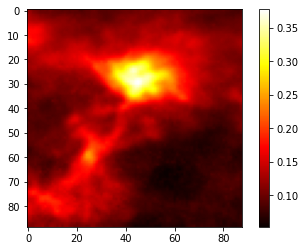

In [26]:
average_spectrum = np.mean(data_cube[:, :,:], axis=0)
plt.imshow(average_spectrum, cmap=cm.hot)
plt.colorbar()


## Average spectrum for a small section of the cube

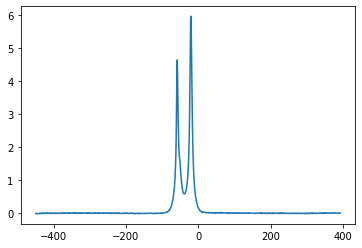

In [27]:
small_region = data_cube[:, 45-10:45+10, 45-10:45+10]
avg_spectrum = np.mean(small_region,axis = (1,2))
plt.plot(velocities, avg_spectrum)


Peaks indexes: [487 512 534]
Peaks are at velocities: [-57.92441016 -37.80400996 -20.09582317]


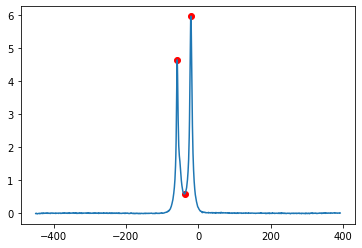

In [28]:
# finding the peaks
peaks_avg, _ = find_peaks(avg_spectrum, width=0.5, height=0.5, )
plt.plot(velocities[peaks_avg], avg_spectrum[peaks_avg], "ro")
plt.plot(velocities, avg_spectrum)
peaks_vel_avg = velocities[peaks_avg]
print("Peaks indexes:", peaks_avg)
print("Peaks are at velocities:", peaks_vel_avg)

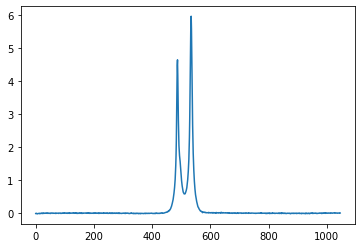

In [29]:
plt.plot(avg_spectrum)

## Noise in the average spectrum from end-channels

In [30]:
noise_left_avg = avg_spectrum[:400]
noise_right_avg = avg_spectrum[600:]

print("Noise in the left tail:", np.std(noise_left_avg))
print("Noise in the right tail:", np.std(noise_right_avg))

Noise in the left tail: 0.005715796
Noise in the right tail: 0.006848051


## Gaussian fitting to the average spectrum

In [31]:
# Left part of the average spectrum
left_avg_velocities = velocities[:512]
left_avg_spectrum = avg_spectrum[:512]

# Right part of the average spectrum
right_avg_velocities = velocities[512:]
right_avg_spectrum = avg_spectrum[512:]


In [32]:
print_moments(left_avg_velocities, left_avg_spectrum)

Mean velocity: -56.475494595667676 km/s
Standard deviation: 4.931279047848197 km/s
Skewness: 375.74184419241845
Kurtosis: -48845.38585375436


In [33]:
print_moments(right_avg_velocities, right_avg_spectrum)

Mean velocity: -19.50592465114145 km/s
Standard deviation: 10.618807570355564 km/s
Skewness: 35.97780260306478
Kurtosis: 2259.8712759742216


Parameters: [  3.45756812 -57.21576853   5.29100578]


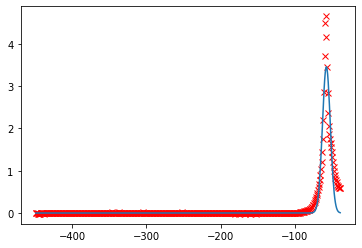

In [34]:
left_avg_guesses = [np.max(left_avg_spectrum), -56.475, 4.931]
right_avg_guesses = [np.max(right_avg_spectrum), -19.506, 10.619]

left_avg_params = gaussian_fit_plot(left_avg_velocities, left_avg_spectrum, left_avg_guesses)

Parameters: [  5.26204505 -20.29384833   4.24610697]


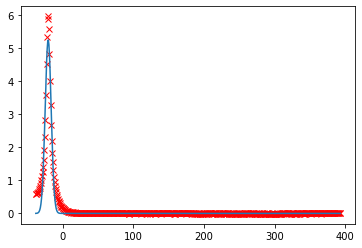

In [35]:
right_avg_params = gaussian_fit_plot(right_avg_velocities, right_avg_spectrum, right_avg_guesses)

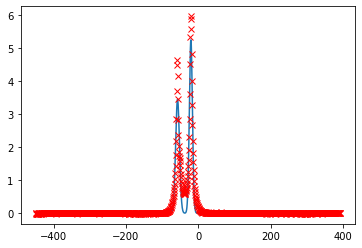

In [36]:
gaussian_combined_avg = gaussian_combined(velocities, left_avg_params, right_avg_params)
plt.plot(velocities, gaussian_combined_avg)
plt.plot(velocities, avg_spectrum, "rx")

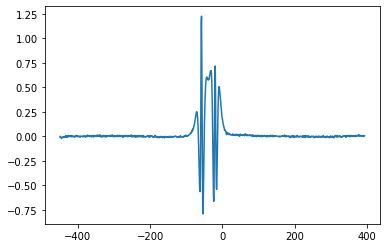

In [37]:
# Residual Plot
plt.plot(velocities, avg_spectrum - gaussian_combined_avg)

## Using ROHSA to decompose the average spectrum

In [38]:
filename = "GHIGLS_G86_Tb.dat"  # @param
fileout = "GHIGLS_G86_Tb_gauss_run_0.dat" #@param
filename_noise = ''
n_gauss = 3           #@param {type:"slider", min:1, max:12, step:1}                                                                                                                                                                                                                             
lambda_amp = 100      #@param {type:"slider", min:0, max:1000, step:1}
lambda_mu = 100       #@param {type:"slider", min:0, max:1000, step:1}
lambda_sig = 100      #@param {type:"slider", min:0, max:1000, step:1}
lambda_var_sig = 0.   #@param {type:"slider", min:0, max:10000, step:1}                                                                                                                                                                                                                                                            
amp_fact_init = 0.66  # times max amplitude of Gaussians for the fit of the mean spectrum                                                                                                                                                                                                                                                       
sig_init = 4.         # dispersion of Gaussians for the fit of the mean spectrum
lb_sig_init = 1.      # lower limit on sigma for the fit of the mean spectrum
ub_sig_init = 12.     # upper limit on sigma for the fit of the mean spectrum
lb_sig = 1.
ub_sig = 100.                                                                                                                                                                                                                                                                
maxiter_init = 15000  # max iteration for L-BFGS-B alogorithm init mean                                                                                                                                                                                                                                        
maxiter = 800         #@param {type:"slider", min:1, max:800, step:1}                                                                                                                                                                                                                                                         
noise = ".false."     # if false - STD map computed by ROHSA between lstd and ustd                                                                                                                                                                                                           
lstd = 1              #@param {type:"slider", min:1, max:400, step:1}                                                                                                                                                                                                                
ustd = 20             #@param {type:"slider", min:1, max:400, step:1}                                                                                                                                                                                                                 
iprint = -1           #@param ["-1", "0", "1"]                                                                                                                                                                                                                                                                                      
iprint_init = -1      # print option init                                              
save_grid = ".false." #@param [".true.", ".false."] 

core = ROHSA(small_region[400:600, :, :], hdr, filename="GHIGLS_G86_Tb.fits")
core.cube2dat(filename=filename)
core.gen_parameters(filename=filename, 
                    fileout=fileout,  
                    n_gauss=n_gauss,
                    lambda_amp=lambda_amp,
                    lambda_mu=lambda_mu,
                    lambda_sig=lambda_sig,
                    lambda_var_sig=lambda_var_sig,
                    amp_fact_init=amp_fact_init,
                    sig_init=sig_init,
                    lb_sig_init=lb_sig_init,
                    ub_sig_init=ub_sig_init,
                    lb_sig=lb_sig,
                    ub_sig=ub_sig,
                    noise=noise,
                    maxiter=maxiter,
                    lstd=lstd,
                    ustd=ustd,
                    iprint_init=iprint_init,
                    iprint=iprint,
                    save_grid=save_grid)


Generate GHIGLS_G86_Tb.dat file readable by fortran
Generate parameters.txt file


In [39]:
def multiple_gaussian(x, parameters):
    # parameters = [amp, mu, sigma, amp, mu, sigma, ...]
    y = 0
    for a,mu,sig in zip(parameters[::3], parameters[1::3], parameters[2::3]):
        y += a*np.exp(-(1/2)*((x-mu)/sig)**2)
    return y

Using 3 gaussians we get the following parameters:

Opening data file


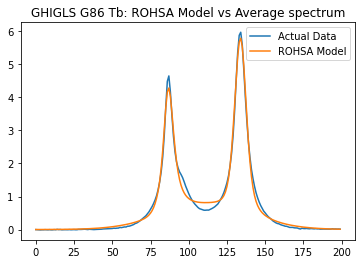

In [40]:
gaussian_from_ROHSA = core.read_gaussian("GHIGLS_G86_Tb_gauss_run_0.dat")
model_from_ROHSA = core.return_result_cube(gaussian_from_ROHSA)

amplitudes = gaussian_from_ROHSA[0::3]
positions = gaussian_from_ROHSA[1::3]
dispersions = gaussian_from_ROHSA[2::3]

actual = small_region[400:600, :, :]

actual_data = plt.plot(np.mean(actual, axis=(1,2)), label="Actual Data")
model = plt.plot(np.mean(model_from_ROHSA, axis=(1,2)), label="ROHSA Model")

plt.title("GHIGLS G86 Tb: ROHSA Model vs Average spectrum")
plt.legend()


Integrated Column Density Maps

In [41]:
def plot_integrated_column_density(cube, rohsa_model):
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 3, 1)
    plt.imshow(np.sum(cube, 0), origin="lower", cmap="inferno")
    plt.title("Actual Data")
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(np.sum(rohsa_model, 0), origin="lower", cmap="inferno")
    plt.title("ROHSA Model")
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.imshow((np.sum(rohsa_model, 0)-np.sum(cube, 0)) /
            np.sum(rohsa_model, 0), origin="lower", cmap="inferno")
    plt.title("Residual")
    plt.colorbar()


def plot_gaussian_parameters(amplitude, position, dispersion):
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 3, 1)
    plt.imshow(amplitude, origin="lower", cmap="inferno")
    plt.title("Amplitudes")
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(position, origin="lower", cmap="coolwarm")
    plt.title("Mean positions")
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.imshow(dispersion, origin="lower", cmap="cubehelix")
    plt.title("Dispersions")
    plt.colorbar()
    
def plot_mosaic_spectra(cube_,integral,rohsa_model,gaussian_from_rohsa):
    #Plot mosaic spectra
    pvalues = np.logspace(-1, 0, len(integral))
    pmin = pvalues[0]
    pmax = pvalues[-1]


    def norm(pval):
        return (pval - pmin) / float(pmax - pmin)


    ny = 4
    nx = 4
    center_y = int(cube_.shape[2]/2)
    center_x = int(cube_.shape[1]/2)
    x = np.arange(cube_.shape[0])
    cb = "magenta"
    cw = "crimson"
    fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10., 6.))
    fig.subplots_adjust(hspace=0, wspace=0, left=0, right=1, top=1, bottom=0)
    for i in np.arange(ny):
        for j in np.arange(nx):
            axs[i][j].step(x, cube_[:, center_y+i, center_x+j],
                        color='cornflowerblue', linewidth=2.)
            axs[i][j].plot(x, rohsa_model[:, center_y+i, center_x+j],
                        linestyle="-", linewidth=2., color="k")
            for k in range(len(integral)):
                axs[i][j].plot(x, core.gauss(x, gaussian_from_rohsa[0::3][k][center_y+i, center_x+j],
                                            gaussian_from_rohsa[1::3][k][center_y +
                                                            i, center_x+j],
                                            gaussian_from_rohsa[2::3][k][center_y+i, center_x+j]),
                            linewidth=2., color=plt.cm.inferno(pvalues[k]))
            if j == 0:
                axs[i][j].set_ylabel(r'T [k]')
            axs[i][j].set_xlabel(r'v [km s$^{-1}$]')


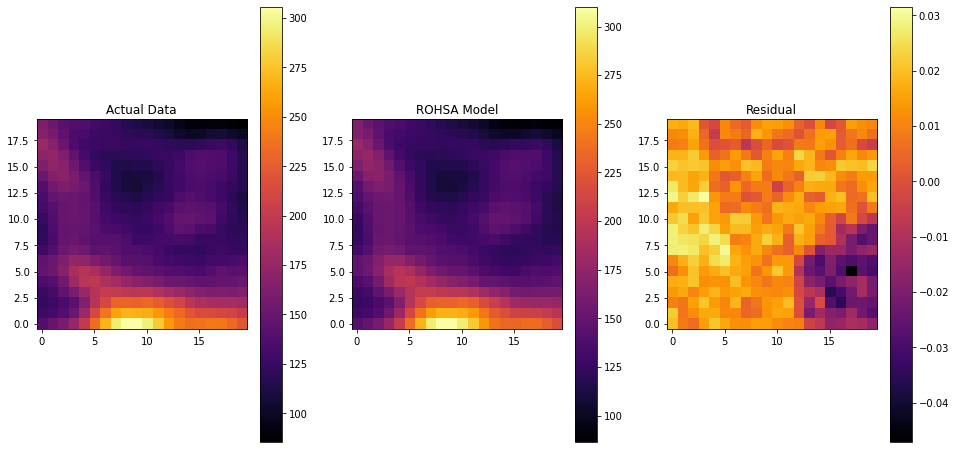

In [42]:
plot_integrated_column_density(actual, model_from_ROHSA)

Map of amplitudes, centers and widths of the Gaussian fits to the average spectrum.

For the first Gaussian:

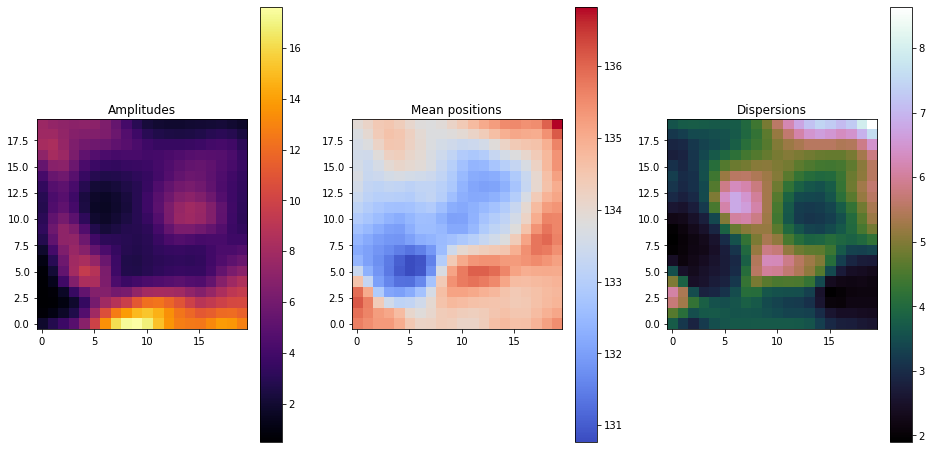

In [43]:
plot_gaussian_parameters(amplitudes[0], positions[0], dispersions[0])

Plotting mosaic spectra

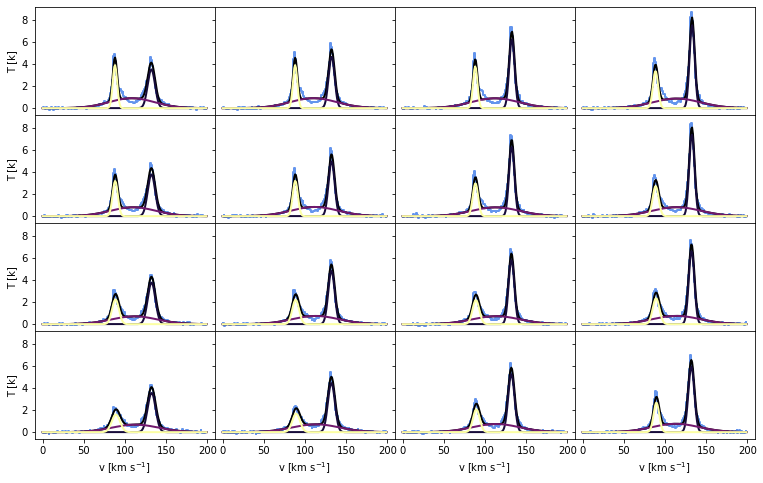

In [44]:
plot_mosaic_spectra(actual, amplitudes*dispersions, model_from_ROHSA, gaussian_from_ROHSA)